# GANomaly
- 2020.08.17 : gen 20 / lr 1e-5

# 개발일지
- 2020.08.15 : 분율 추출 구현 / 이상치 상관계수 추출 구현 / 모델 save, load 구현
- 2020.08.16 : anomaly detect 이미지 저장 구현 / 티타늄(Ti64) 상대 밀도 계산 구현

--- 

# Module

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.utils import save_image
import os
import numpy as np

import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Graph & Animation
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Hyper Parameter

In [2]:
latent_size = 100  # z벡터의 잠재공간(latent space)의 크기
workers = 4    # 0일때, 약 20% 사용 4일 경우 메모리 100%
img_size = 64
channel = 1
epochs = 100
batch_size = 64
learning_rate = 1e-5

# Data and Device

In [3]:
# 이미지 경로, 이미지들 리사이즈 및 텐서형태로 만들기
#data_root = "../../dataset/train"
Ti64_aug_data_root = "../../dataset/aug_train/aug_Ti64"

data_set = dataset.ImageFolder(root = Ti64_aug_data_root, # data_root,
                           transform = transforms.Compose([
                                  #transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

print("size of dataset :", len(data_set))

# 배치로 나누고 셔플하기
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size,
                                         shuffle = True, num_workers = workers, drop_last=True)

# Device setting (GPU or CPU)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("device :", device)

size of dataset : 1020
device : cuda:0


# MODEL

In [4]:
# GANomaly : Generative Adversarial Networks Model using Decoder with AutoEncoder

# === Decoder 모델 ===
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        # Batch Normalization 유무에 따른 G_block 정의
        def DC_conv_block(in_features, out_features):
            block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
            ]
            return block
        
        def DC_deconv_block(in_features, out_features, FIRST=True):
            if FIRST:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 1, 0, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.ConvTranspose2d(in_features, out_features, 4, 2, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            return block
        
        
        # ======================= 픽셀 분포 생성 layer ======================= 
        self.DC_gen_distribution = nn.Sequential(
            # ------ input is latent_size 100 ------ 
            *DC_deconv_block(latent_size, img_size*8, FIRST=True),
            # ------ state size is 512x4x4 ------ 
            *DC_conv_block(img_size*8, img_size*8),
            # ------ state size is 512x4x4 ------   
            *DC_deconv_block(img_size*8, img_size*4, FIRST=False),
            # ------ state size is 256x8x8 ------ 
            *DC_conv_block(img_size*4, img_size*4),
            # ------ state size is 256x8x8 ------ 
            *DC_deconv_block(img_size*4, img_size*2, FIRST=False),
            # ------ state size is 128x16x16 ------ 
            *DC_conv_block(img_size*2, img_size*2),
            # ------ state size is 128x16x16 ------ 
            *DC_deconv_block(img_size*2, img_size, FIRST=False),
        )
        
        # =================== 가짜 이미지 생성 layer =================== 
        self.DC_gen_fake_img = nn.Sequential(
            # ------ state size is 64x32x32 ------ 
            nn.ConvTranspose2d(img_size, 1, 4, 2, 1, bias=False),
            nn.Tanh() # 픽셀값의 범위 : -1 ~ 1로 두기 위해서
            # ------ state size is 1x64x64 ------ 
        )
    
    def forward(self, input):
        distribution = self.DC_gen_distribution(input)
        fake_img = self.DC_gen_fake_img(distribution)
        
        return fake_img


# === Discriminator 모델 ===
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # Batch Normalization 유무에 따른 D_block 정의
        def D_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 layer ==============
        self.D_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *D_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *D_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *D_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *D_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *D_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *D_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *D_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *D_block(img_size*8, img_size*8, MP=True),
        )
        
        # ===================== 이진 분류 layer =====================
        self.D_classification = nn.Sequential(        
            # ------- state size 512x4x4 ------- 
            nn.Conv2d(img_size*8, channel, 4, 1, 0, bias=False),
            #nn.Linear(fms*8*4*4, 1, bias=False),
            nn.Sigmoid()        
        )
        
    def forward(self, input):
        feature = self.D_extract_feature(input)
        classification = self.D_classification(feature)
        
        return classification, feature 


# === Encoder Model ===
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        def EC_block(in_features, out_features, MP=True):
            if MP:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU()
                ]
            else:
                block = [
                    nn.Conv2d(in_features, out_features, 3, 1, 1, bias=False),
                    nn.BatchNorm2d(out_features),
                    nn.ELU(),
                    nn.MaxPool2d(2)
                ]
            return block
        
        # ============== Feature 추출 ==============
        self.EC_extract_feature = nn.Sequential(
            # ------ input is 1 x 64 x 64 ------ 
            *EC_block(channel, img_size, MP=False),
            # ------ input is 64 x 64 x 64 ------ 
            *EC_block(img_size, img_size, MP=True),
            # ------ state is 64 x 32 x 32 ------ 
            *EC_block(img_size, img_size*2, MP=False),
            # ------ state is 128 x 32 x 32 ------ 
            *EC_block(img_size*2, img_size*2, MP=True),
            # ------ state is 128 x 16 x 16 ------ 
            *EC_block(img_size*2, img_size*4, MP=False),
            # ------ state is 256 x 16 x 16 ------ 
            *EC_block(img_size*4, img_size*4, MP=True),
            # ------ state is 256 x 8 x 8 ------ 
            *EC_block(img_size*4, img_size*8, MP=False),
            # ------ state is 512 x 8 x 8 ------ 
            *EC_block(img_size*8, img_size*8, MP=True),
        )
        
        # =============== Encoder Training layer ===============
        self.EC_validate = nn.Sequential(
            # -------state is 512 x 4 x 4-------
            nn.Conv2d(img_size*8, latent_size, 4, 1, 0, bias=False),
            nn.Tanh()
            # -------state is 100 x 97 x 97-------
        )
        
    def forward(self, input):
        feature = self.EC_extract_feature(input)
        validity = self.EC_validate(feature)
        
        return validity

# Loss & Optim

In [5]:
# DC and D 무게 초기화, classname 에 찾는 name가 없다면 -1 ,
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# D,DC,EC 네트워크 모델 객체 선언
D = Discriminator().to(device)
DC = Decoder().to(device)
EC = Encoder().to(device)

# weight initialize/ nn.Module 클래스 안에 apply 함수가 정의되 있음, 각 함수들에 다 적용 하게한다
D.apply(weights_init)
DC.apply(weights_init)
EC.apply(weights_init)

# Binary cross entropy loss and optimizer
DCGAN_criterion = nn.BCELoss()
AE_criterion = nn.MSELoss()

# latent vector에 배치 사이즈 64를 적용
# 학습한 DC로 새로운 것 만들어서 결과 확인 할때 사용
noise_z = torch.randn(img_size, latent_size, 1, 1, device = device)

# D와 DC에 대해 두가지 최적화 설정
D_optimizer = torch.optim.Adam(D.parameters(), lr = learning_rate, betas=(0.5,0.999))
DC_optimizer = torch.optim.Adam(DC.parameters(), lr = learning_rate, betas=(0.5,0.999))
EC_optimizer = torch.optim.Adam(EC.parameters(), lr = learning_rate, betas=(0.5,0.999))

#print(D)
#print(DC)
#print(EC)

def reset_grad():
    D_optimizer.zero_grad()
    DC_optimizer.zero_grad()

---

# Train DCGAN

In [6]:
img_list = []
DC_losses = []
D_losses = []
iters = 0

def train_DCGAN(epoch, learning_DC_per_D = 4):
    global epochs
    global iters
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        # Train D
        real_img = data[0].to(device) # image size: 64x1x64x64(batch, channel, width, height)
        b_size = real_img.size(0) # b_size = 64
        real_labels = torch.ones(b_size, 1).to(device)
        fake_labels = torch.zeros(b_size, 1).to(device)
        
        # (--------------------------real-----------------------------)
        real_classification, _ = D(real_img) # output = D(x)
        real_loss = DCGAN_criterion(real_classification, real_labels) # D(x)=1일 때의 loss
        real_score = real_classification
        D_x = real_score.mean().item() 
            
        # (--------------------------fake-----------------------------)
        z = torch.randn(b_size, latent_size, 1, 1).to(device) # z size :64x100x1x1
        fake_img = DC(z)
        fake_classification, _ = D(fake_img) # output = D(DC(z))
        fake_loss = DCGAN_criterion(fake_classification, fake_labels) # D(DC(z))=0일 때의 loss
        fake_score = fake_classification
        D_DC_z1 = fake_score.mean().item()

        # (------------------Backprop and optimize---------------------)
        D_loss = real_loss + fake_loss
        reset_grad()
        D_loss.backward()
        D_optimizer.step() # D(x)=1, D(DC(z))=0이어야 D가 최적

        
        # Train DC
        #z = torch.randn(b_size,latent_size,1,1,device=device) # z size :64x100x1x1
        for k in range(learning_DC_per_D):
            fake_img = DC(z)
            fake_classification,_ = D(fake_img)  # output : D(DC(z))
            D_DC_z2 = fake_classification.mean().item()
            DC_loss = DCGAN_criterion(fake_classification, real_labels) # D(DC(z))=1일 때의 loss=log(D(DC(z)))

            # (------------------Backprop and optimize---------------------)
            reset_grad()
            DC_loss.backward()
            DC_optimizer.step() # D(DC(z))=1 이어야 DC가 최적
            # ==> D(DC(z))의 값이 0.5로 수렴해야 한다.
        
        
        # print
        print('[%d/%d][%d/%d]\n- D_loss : %.4f / DC_loss : %.4f\n- D(x):%.4f / D(DC(z1)) : %.4f / D(DC(z2)) : %.4f' 
                   %(epoch+1, epochs, i, len(data_loader),D_loss.item(),
                     DC_loss.item(),D_x,D_DC_z1,D_DC_z2))
        
        # Save Losses for plotting later
        DC_losses.append(DC_loss.item())
        D_losses.append(D_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(noise_z).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [7]:
for epoch in range(epochs):
    train_DCGAN(epoch, learning_DC_per_D = 20)

/home/piai/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[1/100][0/15]
- D_loss : 1.3898 / DC_loss : 0.5824
- D(x):0.4967 / D(DC(z1)) : 0.4983 / D(DC(z2)) : 0.5586
[1/100][1/15]
- D_loss : 1.3787 / DC_loss : 0.5758
- D(x):0.4988 / D(DC(z1)) : 0.4949 / D(DC(z2)) : 0.5623
[1/100][2/15]
- D_loss : 1.3743 / DC_loss : 0.5786
- D(x):0.4972 / D(DC(z1)) : 0.4910 / D(DC(z2)) : 0.5607
[1/100][3/15]
- D_loss : 1.3699 / DC_loss : 0.5813
- D(x):0.4974 / D(DC(z1)) : 0.4889 / D(DC(z2)) : 0.5592
[1/100][4/15]
- D_loss : 1.3591 / DC_loss : 0.5872
- D(x):0.4974 / D(DC(z1)) : 0.4834 / D(DC(z2)) : 0.5559
[1/100][5/15]
- D_loss : 1.3562 / DC_loss : 0.5900
- D(x):0.4958 / D(DC(z1)) : 0.4802 / D(DC(z2)) : 0.5544
[1/100][6/15]
- D_loss : 1.3472 / DC_loss : 0.5954
- D(x):0.4981 / D(DC(z1)) : 0.4779 / D(DC(z2)) : 0.5514
[1/100][7/15]
- D_loss : 1.3434 / DC_loss : 0.5985
- D(x):0.4968 / D(DC(z1)) : 0.4745 / D(DC(z2)) : 0.5497
[1/100][8/15]
- D_loss : 1.3378 / DC_loss : 0.6003
- D(x):0.4960 / D(DC(z1)) : 0.4706 / D(DC(z2)) : 0.5487
[1/100][9/15]
- D_loss : 1.3344 / DC_

[6/100][2/15]
- D_loss : 1.5277 / DC_loss : 0.6286
- D(x):0.4671 / D(DC(z1)) : 0.5346 / D(DC(z2)) : 0.5334
[6/100][3/15]
- D_loss : 1.5283 / DC_loss : 0.6335
- D(x):0.4651 / D(DC(z1)) : 0.5329 / D(DC(z2)) : 0.5307
[6/100][4/15]
- D_loss : 1.5157 / DC_loss : 0.6412
- D(x):0.4681 / D(DC(z1)) : 0.5302 / D(DC(z2)) : 0.5267
[6/100][5/15]
- D_loss : 1.5010 / DC_loss : 0.6499
- D(x):0.4709 / D(DC(z1)) : 0.5259 / D(DC(z2)) : 0.5221
[6/100][6/15]
- D_loss : 1.4958 / DC_loss : 0.6579
- D(x):0.4691 / D(DC(z1)) : 0.5215 / D(DC(z2)) : 0.5180
[6/100][7/15]
- D_loss : 1.4858 / DC_loss : 0.6646
- D(x):0.4698 / D(DC(z1)) : 0.5176 / D(DC(z2)) : 0.5145
[6/100][8/15]
- D_loss : 1.4855 / DC_loss : 0.6705
- D(x):0.4665 / D(DC(z1)) : 0.5141 / D(DC(z2)) : 0.5115
[6/100][9/15]
- D_loss : 1.4785 / DC_loss : 0.6760
- D(x):0.4669 / D(DC(z1)) : 0.5112 / D(DC(z2)) : 0.5086
[6/100][10/15]
- D_loss : 1.4749 / DC_loss : 0.6790
- D(x):0.4660 / D(DC(z1)) : 0.5082 / D(DC(z2)) : 0.5071
[6/100][11/15]
- D_loss : 1.4721 / D

[11/100][4/15]
- D_loss : 1.3982 / DC_loss : 0.7535
- D(x):0.4711 / D(DC(z1)) : 0.4747 / D(DC(z2)) : 0.4707
[11/100][5/15]
- D_loss : 1.3992 / DC_loss : 0.7636
- D(x):0.4670 / D(DC(z1)) : 0.4709 / D(DC(z2)) : 0.4660
[11/100][6/15]
- D_loss : 1.3949 / DC_loss : 0.7743
- D(x):0.4649 / D(DC(z1)) : 0.4661 / D(DC(z2)) : 0.4610
[11/100][7/15]
- D_loss : 1.3704 / DC_loss : 0.7851
- D(x):0.4721 / D(DC(z1)) : 0.4612 / D(DC(z2)) : 0.4561
[11/100][8/15]
- D_loss : 1.3694 / DC_loss : 0.7957
- D(x):0.4682 / D(DC(z1)) : 0.4562 / D(DC(z2)) : 0.4513
[11/100][9/15]
- D_loss : 1.3596 / DC_loss : 0.8060
- D(x):0.4687 / D(DC(z1)) : 0.4514 / D(DC(z2)) : 0.4466
[11/100][10/15]
- D_loss : 1.3557 / DC_loss : 0.8147
- D(x):0.4665 / D(DC(z1)) : 0.4468 / D(DC(z2)) : 0.4428
[11/100][11/15]
- D_loss : 1.3447 / DC_loss : 0.8206
- D(x):0.4685 / D(DC(z1)) : 0.4429 / D(DC(z2)) : 0.4402
[11/100][12/15]
- D_loss : 1.3383 / DC_loss : 0.8244
- D(x):0.4693 / D(DC(z1)) : 0.4404 / D(DC(z2)) : 0.4385
[11/100][13/15]
- D_loss 

[16/100][5/15]
- D_loss : 1.3357 / DC_loss : 0.8162
- D(x):0.4756 / D(DC(z1)) : 0.4464 / D(DC(z2)) : 0.4421
[16/100][6/15]
- D_loss : 1.3335 / DC_loss : 0.8257
- D(x):0.4730 / D(DC(z1)) : 0.4422 / D(DC(z2)) : 0.4379
[16/100][7/15]
- D_loss : 1.3177 / DC_loss : 0.8349
- D(x):0.4769 / D(DC(z1)) : 0.4381 / D(DC(z2)) : 0.4339
[16/100][8/15]
- D_loss : 1.3048 / DC_loss : 0.8435
- D(x):0.4797 / D(DC(z1)) : 0.4340 / D(DC(z2)) : 0.4302
[16/100][9/15]
- D_loss : 1.3018 / DC_loss : 0.8524
- D(x):0.4780 / D(DC(z1)) : 0.4303 / D(DC(z2)) : 0.4264
[16/100][10/15]
- D_loss : 1.2924 / DC_loss : 0.8610
- D(x):0.4793 / D(DC(z1)) : 0.4265 / D(DC(z2)) : 0.4228
[16/100][11/15]
- D_loss : 1.2928 / DC_loss : 0.8690
- D(x):0.4761 / D(DC(z1)) : 0.4229 / D(DC(z2)) : 0.4194
[16/100][12/15]
- D_loss : 1.2796 / DC_loss : 0.8771
- D(x):0.4795 / D(DC(z1)) : 0.4195 / D(DC(z2)) : 0.4160
[16/100][13/15]
- D_loss : 1.2870 / DC_loss : 0.8843
- D(x):0.4733 / D(DC(z1)) : 0.4161 / D(DC(z2)) : 0.4130
[16/100][14/15]
- D_loss

[21/100][6/15]
- D_loss : 1.3351 / DC_loss : 0.7816
- D(x):0.4901 / D(DC(z1)) : 0.4628 / D(DC(z2)) : 0.4577
[21/100][7/15]
- D_loss : 1.3213 / DC_loss : 0.7916
- D(x):0.4923 / D(DC(z1)) : 0.4579 / D(DC(z2)) : 0.4531
[21/100][8/15]
- D_loss : 1.3150 / DC_loss : 0.8001
- D(x):0.4913 / D(DC(z1)) : 0.4534 / D(DC(z2)) : 0.4493
[21/100][9/15]
- D_loss : 1.3155 / DC_loss : 0.8066
- D(x):0.4878 / D(DC(z1)) : 0.4495 / D(DC(z2)) : 0.4464
[21/100][10/15]
- D_loss : 1.3020 / DC_loss : 0.8097
- D(x):0.4918 / D(DC(z1)) : 0.4467 / D(DC(z2)) : 0.4450
[21/100][11/15]
- D_loss : 1.2892 / DC_loss : 0.8117
- D(x):0.4969 / D(DC(z1)) : 0.4454 / D(DC(z2)) : 0.4441
[21/100][12/15]
- D_loss : 1.2942 / DC_loss : 0.8160
- D(x):0.4935 / D(DC(z1)) : 0.4445 / D(DC(z2)) : 0.4422
[21/100][13/15]
- D_loss : 1.3006 / DC_loss : 0.8223
- D(x):0.4886 / D(DC(z1)) : 0.4424 / D(DC(z2)) : 0.4394
[21/100][14/15]
- D_loss : 1.2858 / DC_loss : 0.8261
- D(x):0.4938 / D(DC(z1)) : 0.4400 / D(DC(z2)) : 0.4378
[22/100][0/15]
- D_loss

[26/100][7/15]
- D_loss : 1.2129 / DC_loss : 0.9114
- D(x):0.4989 / D(DC(z1)) : 0.4039 / D(DC(z2)) : 0.4020
[26/100][8/15]
- D_loss : 1.2216 / DC_loss : 0.9118
- D(x):0.4933 / D(DC(z1)) : 0.4022 / D(DC(z2)) : 0.4018
[26/100][9/15]
- D_loss : 1.2140 / DC_loss : 0.9019
- D(x):0.4969 / D(DC(z1)) : 0.4022 / D(DC(z2)) : 0.4058
[26/100][10/15]
- D_loss : 1.2236 / DC_loss : 0.8626
- D(x):0.4960 / D(DC(z1)) : 0.4066 / D(DC(z2)) : 0.4221
[26/100][11/15]
- D_loss : 1.2432 / DC_loss : 0.8393
- D(x):0.5002 / D(DC(z1)) : 0.4231 / D(DC(z2)) : 0.4320
[26/100][12/15]
- D_loss : 1.2617 / DC_loss : 0.8317
- D(x):0.4993 / D(DC(z1)) : 0.4327 / D(DC(z2)) : 0.4353
[26/100][13/15]
- D_loss : 1.2622 / DC_loss : 0.8351
- D(x):0.5017 / D(DC(z1)) : 0.4357 / D(DC(z2)) : 0.4339
[26/100][14/15]
- D_loss : 1.2625 / DC_loss : 0.8408
- D(x):0.5002 / D(DC(z1)) : 0.4342 / D(DC(z2)) : 0.4313
[27/100][0/15]
- D_loss : 1.2654 / DC_loss : 0.8455
- D(x):0.4965 / D(DC(z1)) : 0.4316 / D(DC(z2)) : 0.4294
[27/100][1/15]
- D_loss

[31/100][8/15]
- D_loss : 1.1646 / DC_loss : 0.9396
- D(x):0.5154 / D(DC(z1)) : 0.3944 / D(DC(z2)) : 0.3908
[31/100][9/15]
- D_loss : 1.1597 / DC_loss : 0.9447
- D(x):0.5151 / D(DC(z1)) : 0.3912 / D(DC(z2)) : 0.3888
[31/100][10/15]
- D_loss : 1.1516 / DC_loss : 0.9456
- D(x):0.5176 / D(DC(z1)) : 0.3890 / D(DC(z2)) : 0.3884
[31/100][11/15]
- D_loss : 1.1507 / DC_loss : 0.9427
- D(x):0.5177 / D(DC(z1)) : 0.3887 / D(DC(z2)) : 0.3896
[31/100][12/15]
- D_loss : 1.1657 / DC_loss : 0.9121
- D(x):0.5112 / D(DC(z1)) : 0.3902 / D(DC(z2)) : 0.4017
[31/100][13/15]
- D_loss : 1.1776 / DC_loss : 0.8940
- D(x):0.5157 / D(DC(z1)) : 0.4026 / D(DC(z2)) : 0.4090
[31/100][14/15]
- D_loss : 1.1799 / DC_loss : 0.8513
- D(x):0.5204 / D(DC(z1)) : 0.4094 / D(DC(z2)) : 0.4269
[32/100][0/15]
- D_loss : 1.2136 / DC_loss : 0.8131
- D(x):0.5204 / D(DC(z1)) : 0.4290 / D(DC(z2)) : 0.4435
[32/100][1/15]
- D_loss : 1.2452 / DC_loss : 0.8194
- D(x):0.5181 / D(DC(z1)) : 0.4441 / D(DC(z2)) : 0.4407
[32/100][2/15]
- D_loss

[36/100][9/15]
- D_loss : 1.1511 / DC_loss : 0.9518
- D(x):0.5210 / D(DC(z1)) : 0.3923 / D(DC(z2)) : 0.3861
[36/100][10/15]
- D_loss : 1.1475 / DC_loss : 0.9631
- D(x):0.5175 / D(DC(z1)) : 0.3864 / D(DC(z2)) : 0.3817
[36/100][11/15]
- D_loss : 1.1178 / DC_loss : 0.9692
- D(x):0.5293 / D(DC(z1)) : 0.3821 / D(DC(z2)) : 0.3794
[36/100][12/15]
- D_loss : 1.1198 / DC_loss : 0.9626
- D(x):0.5264 / D(DC(z1)) : 0.3799 / D(DC(z2)) : 0.3819
[36/100][13/15]
- D_loss : 1.1163 / DC_loss : 0.9552
- D(x):0.5305 / D(DC(z1)) : 0.3825 / D(DC(z2)) : 0.3847
[36/100][14/15]
- D_loss : 1.1409 / DC_loss : 0.9557
- D(x):0.5201 / D(DC(z1)) : 0.3853 / D(DC(z2)) : 0.3845
[37/100][0/15]
- D_loss : 1.1271 / DC_loss : 0.9619
- D(x):0.5270 / D(DC(z1)) : 0.3851 / D(DC(z2)) : 0.3821
[37/100][1/15]
- D_loss : 1.1235 / DC_loss : 0.9726
- D(x):0.5267 / D(DC(z1)) : 0.3825 / D(DC(z2)) : 0.3781
[37/100][2/15]
- D_loss : 1.1159 / DC_loss : 0.9837
- D(x):0.5273 / D(DC(z1)) : 0.3784 / D(DC(z2)) : 0.3739
[37/100][3/15]
- D_loss

[41/100][10/15]
- D_loss : 1.1175 / DC_loss : 0.8855
- D(x):0.5614 / D(DC(z1)) : 0.4172 / D(DC(z2)) : 0.4125
[41/100][11/15]
- D_loss : 1.1024 / DC_loss : 0.9017
- D(x):0.5652 / D(DC(z1)) : 0.4124 / D(DC(z2)) : 0.4059
[41/100][12/15]
- D_loss : 1.0901 / DC_loss : 0.9220
- D(x):0.5643 / D(DC(z1)) : 0.4041 / D(DC(z2)) : 0.3977
[41/100][13/15]
- D_loss : 1.0887 / DC_loss : 0.9368
- D(x):0.5599 / D(DC(z1)) : 0.3987 / D(DC(z2)) : 0.3919
[41/100][14/15]
- D_loss : 1.0753 / DC_loss : 0.9550
- D(x):0.5612 / D(DC(z1)) : 0.3918 / D(DC(z2)) : 0.3848
[42/100][0/15]
- D_loss : 1.0617 / DC_loss : 0.9639
- D(x):0.5627 / D(DC(z1)) : 0.3854 / D(DC(z2)) : 0.3814
[42/100][1/15]
- D_loss : 1.0640 / DC_loss : 0.9662
- D(x):0.5581 / D(DC(z1)) : 0.3815 / D(DC(z2)) : 0.3805
[42/100][2/15]
- D_loss : 1.0550 / DC_loss : 0.9650
- D(x):0.5627 / D(DC(z1)) : 0.3809 / D(DC(z2)) : 0.3810
[42/100][3/15]
- D_loss : 1.0573 / DC_loss : 0.9670
- D(x):0.5619 / D(DC(z1)) : 0.3814 / D(DC(z2)) : 0.3802
[42/100][4/15]
- D_loss

[46/100][11/15]
- D_loss : 0.9972 / DC_loss : 1.0246
- D(x):0.5847 / D(DC(z1)) : 0.3689 / D(DC(z2)) : 0.3589
[46/100][12/15]
- D_loss : 0.9926 / DC_loss : 1.0494
- D(x):0.5789 / D(DC(z1)) : 0.3594 / D(DC(z2)) : 0.3502
[46/100][13/15]
- D_loss : 0.9721 / DC_loss : 1.0746
- D(x):0.5828 / D(DC(z1)) : 0.3506 / D(DC(z2)) : 0.3414
[46/100][14/15]
- D_loss : 0.9802 / DC_loss : 1.0948
- D(x):0.5704 / D(DC(z1)) : 0.3417 / D(DC(z2)) : 0.3346
[47/100][0/15]
- D_loss : 0.9664 / DC_loss : 1.1117
- D(x):0.5722 / D(DC(z1)) : 0.3349 / D(DC(z2)) : 0.3290
[47/100][1/15]
- D_loss : 0.9404 / DC_loss : 1.1299
- D(x):0.5824 / D(DC(z1)) : 0.3292 / D(DC(z2)) : 0.3231
[47/100][2/15]
- D_loss : 0.9341 / DC_loss : 1.1452
- D(x):0.5809 / D(DC(z1)) : 0.3233 / D(DC(z2)) : 0.3182
[47/100][3/15]
- D_loss : 0.9292 / DC_loss : 1.1490
- D(x):0.5797 / D(DC(z1)) : 0.3184 / D(DC(z2)) : 0.3169
[47/100][4/15]
- D_loss : 0.9176 / DC_loss : 1.0614
- D(x):0.5855 / D(DC(z1)) : 0.3175 / D(DC(z2)) : 0.3460
[47/100][5/15]
- D_loss 

[51/100][12/15]
- D_loss : 1.3860 / DC_loss : 0.7082
- D(x):0.4889 / D(DC(z1)) : 0.4871 / D(DC(z2)) : 0.4930
[51/100][13/15]
- D_loss : 1.3495 / DC_loss : 0.7160
- D(x):0.4990 / D(DC(z1)) : 0.4792 / D(DC(z2)) : 0.4891
[51/100][14/15]
- D_loss : 1.3844 / DC_loss : 0.7129
- D(x):0.4836 / D(DC(z1)) : 0.4812 / D(DC(z2)) : 0.4905
[52/100][0/15]
- D_loss : 1.3753 / DC_loss : 0.6999
- D(x):0.4955 / D(DC(z1)) : 0.4890 / D(DC(z2)) : 0.4971
[52/100][1/15]
- D_loss : 1.3762 / DC_loss : 0.7133
- D(x):0.4829 / D(DC(z1)) : 0.4764 / D(DC(z2)) : 0.4903
[52/100][2/15]
- D_loss : 1.3840 / DC_loss : 0.7067
- D(x):0.4857 / D(DC(z1)) : 0.4832 / D(DC(z2)) : 0.4938
[52/100][3/15]
- D_loss : 1.3735 / DC_loss : 0.7218
- D(x):0.4800 / D(DC(z1)) : 0.4714 / D(DC(z2)) : 0.4861
[52/100][4/15]
- D_loss : 1.3644 / DC_loss : 0.7295
- D(x):0.4872 / D(DC(z1)) : 0.4747 / D(DC(z2)) : 0.4824
[52/100][5/15]
- D_loss : 1.3587 / DC_loss : 0.7206
- D(x):0.4905 / D(DC(z1)) : 0.4754 / D(DC(z2)) : 0.4867
[52/100][6/15]
- D_loss :

[56/100][13/15]
- D_loss : 1.3482 / DC_loss : 0.6951
- D(x):0.4992 / D(DC(z1)) : 0.4792 / D(DC(z2)) : 0.4992
[56/100][14/15]
- D_loss : 1.3891 / DC_loss : 0.6963
- D(x):0.4878 / D(DC(z1)) : 0.4883 / D(DC(z2)) : 0.4986
[57/100][0/15]
- D_loss : 1.3895 / DC_loss : 0.6863
- D(x):0.4954 / D(DC(z1)) : 0.4962 / D(DC(z2)) : 0.5036
[57/100][1/15]
- D_loss : 1.3653 / DC_loss : 0.6810
- D(x):0.5131 / D(DC(z1)) : 0.5016 / D(DC(z2)) : 0.5063
[57/100][2/15]
- D_loss : 1.3925 / DC_loss : 0.6867
- D(x):0.4921 / D(DC(z1)) : 0.4945 / D(DC(z2)) : 0.5034
[57/100][3/15]
- D_loss : 1.3622 / DC_loss : 0.6964
- D(x):0.4989 / D(DC(z1)) : 0.4860 / D(DC(z2)) : 0.4985
[57/100][4/15]
- D_loss : 1.3306 / DC_loss : 0.6979
- D(x):0.5136 / D(DC(z1)) : 0.4848 / D(DC(z2)) : 0.4977
[57/100][5/15]
- D_loss : 1.3721 / DC_loss : 0.6798
- D(x):0.5039 / D(DC(z1)) : 0.4961 / D(DC(z2)) : 0.5069
[57/100][6/15]
- D_loss : 1.3892 / DC_loss : 0.6909
- D(x):0.4912 / D(DC(z1)) : 0.4918 / D(DC(z2)) : 0.5014
[57/100][7/15]
- D_loss : 

[61/100][14/15]
- D_loss : 1.3532 / DC_loss : 0.6916
- D(x):0.5020 / D(DC(z1)) : 0.4845 / D(DC(z2)) : 0.5012
[62/100][0/15]
- D_loss : 1.3208 / DC_loss : 0.7101
- D(x):0.5085 / D(DC(z1)) : 0.4744 / D(DC(z2)) : 0.4919
[62/100][1/15]
- D_loss : 1.3114 / DC_loss : 0.7030
- D(x):0.5128 / D(DC(z1)) : 0.4739 / D(DC(z2)) : 0.4955
[62/100][2/15]
- D_loss : 1.3222 / DC_loss : 0.7007
- D(x):0.5137 / D(DC(z1)) : 0.4804 / D(DC(z2)) : 0.4965
[62/100][3/15]
- D_loss : 1.3306 / DC_loss : 0.6924
- D(x):0.5154 / D(DC(z1)) : 0.4862 / D(DC(z2)) : 0.5008
[62/100][4/15]
- D_loss : 1.3395 / DC_loss : 0.7017
- D(x):0.5093 / D(DC(z1)) : 0.4845 / D(DC(z2)) : 0.4964
[62/100][5/15]
- D_loss : 1.3355 / DC_loss : 0.7193
- D(x):0.5019 / D(DC(z1)) : 0.4746 / D(DC(z2)) : 0.4879
[62/100][6/15]
- D_loss : 1.3265 / DC_loss : 0.7237
- D(x):0.4968 / D(DC(z1)) : 0.4644 / D(DC(z2)) : 0.4854
[62/100][7/15]
- D_loss : 1.3224 / DC_loss : 0.7479
- D(x):0.4979 / D(DC(z1)) : 0.4634 / D(DC(z2)) : 0.4738
[62/100][8/15]
- D_loss : 1

[67/100][0/15]
- D_loss : 1.3034 / DC_loss : 0.6763
- D(x):0.5282 / D(DC(z1)) : 0.4854 / D(DC(z2)) : 0.5087
[67/100][1/15]
- D_loss : 1.3398 / DC_loss : 0.6829
- D(x):0.5079 / D(DC(z1)) : 0.4839 / D(DC(z2)) : 0.5054
[67/100][2/15]
- D_loss : 1.3401 / DC_loss : 0.6756
- D(x):0.5157 / D(DC(z1)) : 0.4918 / D(DC(z2)) : 0.5089
[67/100][3/15]
- D_loss : 1.3167 / DC_loss : 0.6759
- D(x):0.5226 / D(DC(z1)) : 0.4867 / D(DC(z2)) : 0.5088
[67/100][4/15]
- D_loss : 1.3117 / DC_loss : 0.6920
- D(x):0.5207 / D(DC(z1)) : 0.4823 / D(DC(z2)) : 0.5007
[67/100][5/15]
- D_loss : 1.3043 / DC_loss : 0.6873
- D(x):0.5155 / D(DC(z1)) : 0.4732 / D(DC(z2)) : 0.5030
[67/100][6/15]
- D_loss : 1.2667 / DC_loss : 0.7261
- D(x):0.5182 / D(DC(z1)) : 0.4561 / D(DC(z2)) : 0.4840
[67/100][7/15]
- D_loss : 1.2711 / DC_loss : 0.6863
- D(x):0.5272 / D(DC(z1)) : 0.4675 / D(DC(z2)) : 0.5037
[67/100][8/15]
- D_loss : 1.2876 / DC_loss : 0.6998
- D(x):0.5131 / D(DC(z1)) : 0.4618 / D(DC(z2)) : 0.4969
[67/100][9/15]
- D_loss : 1.

[72/100][1/15]
- D_loss : 1.3207 / DC_loss : 0.6573
- D(x):0.5237 / D(DC(z1)) : 0.4898 / D(DC(z2)) : 0.5183
[72/100][2/15]
- D_loss : 1.2719 / DC_loss : 0.6895
- D(x):0.5319 / D(DC(z1)) : 0.4727 / D(DC(z2)) : 0.5021
[72/100][3/15]
- D_loss : 1.2706 / DC_loss : 0.7015
- D(x):0.5302 / D(DC(z1)) : 0.4701 / D(DC(z2)) : 0.4961
[72/100][4/15]
- D_loss : 1.2520 / DC_loss : 0.7473
- D(x):0.5107 / D(DC(z1)) : 0.4396 / D(DC(z2)) : 0.4743
[72/100][5/15]
- D_loss : 1.2847 / DC_loss : 0.7244
- D(x):0.5005 / D(DC(z1)) : 0.4463 / D(DC(z2)) : 0.4853
[72/100][6/15]
- D_loss : 1.2390 / DC_loss : 0.7234
- D(x):0.5236 / D(DC(z1)) : 0.4460 / D(DC(z2)) : 0.4863
[72/100][7/15]
- D_loss : 1.2241 / DC_loss : 0.7512
- D(x):0.5251 / D(DC(z1)) : 0.4395 / D(DC(z2)) : 0.4727
[72/100][8/15]
- D_loss : 1.3026 / DC_loss : 0.6920
- D(x):0.5114 / D(DC(z1)) : 0.4670 / D(DC(z2)) : 0.5020
[72/100][9/15]
- D_loss : 1.2532 / DC_loss : 0.6958
- D(x):0.5179 / D(DC(z1)) : 0.4475 / D(DC(z2)) : 0.4990
[72/100][10/15]
- D_loss : 1

[77/100][2/15]
- D_loss : 1.2167 / DC_loss : 0.7614
- D(x):0.5223 / D(DC(z1)) : 0.4321 / D(DC(z2)) : 0.4676
[77/100][3/15]
- D_loss : 1.2774 / DC_loss : 0.7111
- D(x):0.5029 / D(DC(z1)) : 0.4450 / D(DC(z2)) : 0.4917
[77/100][4/15]
- D_loss : 1.2509 / DC_loss : 0.6920
- D(x):0.5208 / D(DC(z1)) : 0.4497 / D(DC(z2)) : 0.5012
[77/100][5/15]
- D_loss : 1.2070 / DC_loss : 0.6775
- D(x):0.5595 / D(DC(z1)) : 0.4648 / D(DC(z2)) : 0.5086
[77/100][6/15]
- D_loss : 1.2340 / DC_loss : 0.7156
- D(x):0.5475 / D(DC(z1)) : 0.4669 / D(DC(z2)) : 0.4920
[77/100][7/15]
- D_loss : 1.2635 / DC_loss : 0.7505
- D(x):0.4981 / D(DC(z1)) : 0.4306 / D(DC(z2)) : 0.4744
[77/100][8/15]
- D_loss : 1.3005 / DC_loss : 0.7395
- D(x):0.4915 / D(DC(z1)) : 0.4432 / D(DC(z2)) : 0.4805
[77/100][9/15]
- D_loss : 1.2673 / DC_loss : 0.7019
- D(x):0.5167 / D(DC(z1)) : 0.4528 / D(DC(z2)) : 0.4979
[77/100][10/15]
- D_loss : 1.2253 / DC_loss : 0.6793
- D(x):0.5388 / D(DC(z1)) : 0.4536 / D(DC(z2)) : 0.5072
[77/100][11/15]
- D_loss : 

[82/100][3/15]
- D_loss : 1.2355 / DC_loss : 0.7218
- D(x):0.5327 / D(DC(z1)) : 0.4528 / D(DC(z2)) : 0.4864
[82/100][4/15]
- D_loss : 1.1623 / DC_loss : 0.7177
- D(x):0.5596 / D(DC(z1)) : 0.4396 / D(DC(z2)) : 0.4881
[82/100][5/15]
- D_loss : 1.2835 / DC_loss : 0.6799
- D(x):0.5173 / D(DC(z1)) : 0.4634 / D(DC(z2)) : 0.5069
[82/100][6/15]
- D_loss : 1.2402 / DC_loss : 0.6932
- D(x):0.5565 / D(DC(z1)) : 0.4795 / D(DC(z2)) : 0.5005
[82/100][7/15]
- D_loss : 1.2080 / DC_loss : 0.7495
- D(x):0.5200 / D(DC(z1)) : 0.4246 / D(DC(z2)) : 0.4740
[82/100][8/15]
- D_loss : 1.1853 / DC_loss : 0.7491
- D(x):0.5416 / D(DC(z1)) : 0.4348 / D(DC(z2)) : 0.4748
[82/100][9/15]
- D_loss : 1.1817 / DC_loss : 0.6634
- D(x):0.5364 / D(DC(z1)) : 0.4267 / D(DC(z2)) : 0.5166
[82/100][10/15]
- D_loss : 1.1792 / DC_loss : 0.7009
- D(x):0.5542 / D(DC(z1)) : 0.4442 / D(DC(z2)) : 0.4978
[82/100][11/15]
- D_loss : 1.1954 / DC_loss : 0.7178
- D(x):0.5572 / D(DC(z1)) : 0.4555 / D(DC(z2)) : 0.4907
[82/100][12/15]
- D_loss :

[87/100][4/15]
- D_loss : 1.1127 / DC_loss : 0.6696
- D(x):0.5264 / D(DC(z1)) : 0.3735 / D(DC(z2)) : 0.5122
[87/100][5/15]
- D_loss : 1.3420 / DC_loss : 0.6232
- D(x):0.5234 / D(DC(z1)) : 0.4996 / D(DC(z2)) : 0.5369
[87/100][6/15]
- D_loss : 1.2863 / DC_loss : 0.6866
- D(x):0.5472 / D(DC(z1)) : 0.4935 / D(DC(z2)) : 0.5058
[87/100][7/15]
- D_loss : 1.3852 / DC_loss : 0.7084
- D(x):0.4768 / D(DC(z1)) : 0.4710 / D(DC(z2)) : 0.4965
[87/100][8/15]
- D_loss : 1.2724 / DC_loss : 0.6825
- D(x):0.5170 / D(DC(z1)) : 0.4509 / D(DC(z2)) : 0.5074
[87/100][9/15]
- D_loss : 1.2114 / DC_loss : 0.6813
- D(x):0.5733 / D(DC(z1)) : 0.4767 / D(DC(z2)) : 0.5075
[87/100][10/15]
- D_loss : 1.2044 / DC_loss : 0.7361
- D(x):0.5367 / D(DC(z1)) : 0.4391 / D(DC(z2)) : 0.4804
[87/100][11/15]
- D_loss : 1.1959 / DC_loss : 0.7320
- D(x):0.5556 / D(DC(z1)) : 0.4525 / D(DC(z2)) : 0.4829
[87/100][12/15]
- D_loss : 1.1388 / DC_loss : 0.7897
- D(x):0.5148 / D(DC(z1)) : 0.3747 / D(DC(z2)) : 0.4570
[87/100][13/15]
- D_loss 

[92/100][5/15]
- D_loss : 1.0713 / DC_loss : 0.7084
- D(x):0.5748 / D(DC(z1)) : 0.4024 / D(DC(z2)) : 0.4944
[92/100][6/15]
- D_loss : 1.1461 / DC_loss : 0.6876
- D(x):0.5031 / D(DC(z1)) : 0.3656 / D(DC(z2)) : 0.5040
[92/100][7/15]
- D_loss : 1.0706 / DC_loss : 0.7241
- D(x):0.5635 / D(DC(z1)) : 0.3900 / D(DC(z2)) : 0.4875
[92/100][8/15]
- D_loss : 1.0133 / DC_loss : 0.7608
- D(x):0.5681 / D(DC(z1)) : 0.3581 / D(DC(z2)) : 0.4678
[92/100][9/15]
- D_loss : 1.0656 / DC_loss : 0.8213
- D(x):0.6131 / D(DC(z1)) : 0.4368 / D(DC(z2)) : 0.4419
[92/100][10/15]
- D_loss : 1.0378 / DC_loss : 0.8001
- D(x):0.5788 / D(DC(z1)) : 0.3856 / D(DC(z2)) : 0.4518
[92/100][11/15]
- D_loss : 1.1795 / DC_loss : 0.7720
- D(x):0.5154 / D(DC(z1)) : 0.4010 / D(DC(z2)) : 0.4636
[92/100][12/15]
- D_loss : 1.2141 / DC_loss : 0.6814
- D(x):0.5383 / D(DC(z1)) : 0.4469 / D(DC(z2)) : 0.5078
[92/100][13/15]
- D_loss : 0.9846 / DC_loss : 0.7756
- D(x):0.6198 / D(DC(z1)) : 0.3952 / D(DC(z2)) : 0.4626
[92/100][14/15]
- D_loss

[97/100][6/15]
- D_loss : 0.9401 / DC_loss : 0.7408
- D(x):0.5836 / D(DC(z1)) : 0.3279 / D(DC(z2)) : 0.4774
[97/100][7/15]
- D_loss : 0.9153 / DC_loss : 0.6744
- D(x):0.6391 / D(DC(z1)) : 0.3712 / D(DC(z2)) : 0.5101
[97/100][8/15]
- D_loss : 0.9756 / DC_loss : 0.6991
- D(x):0.6280 / D(DC(z1)) : 0.3973 / D(DC(z2)) : 0.4988
[97/100][9/15]
- D_loss : 1.0519 / DC_loss : 0.6607
- D(x):0.6444 / D(DC(z1)) : 0.4552 / D(DC(z2)) : 0.5178
[97/100][10/15]
- D_loss : 0.9147 / DC_loss : 0.6923
- D(x):0.6079 / D(DC(z1)) : 0.3380 / D(DC(z2)) : 0.5020
[97/100][11/15]
- D_loss : 1.1111 / DC_loss : 0.5474
- D(x):0.5696 / D(DC(z1)) : 0.4193 / D(DC(z2)) : 0.5796
[97/100][12/15]
- D_loss : 1.0069 / DC_loss : 0.5543
- D(x):0.5724 / D(DC(z1)) : 0.3595 / D(DC(z2)) : 0.5757
[97/100][13/15]
- D_loss : 0.9320 / DC_loss : 0.4957
- D(x):0.6698 / D(DC(z1)) : 0.4098 / D(DC(z2)) : 0.6116
[97/100][14/15]
- D_loss : 1.1481 / DC_loss : 0.4671
- D(x):0.5877 / D(DC(z1)) : 0.4557 / D(DC(z2)) : 0.6295
[98/100][0/15]
- D_loss

# Animation

In [8]:
def animate_gen_imgs():
    fig = plt.figure(figsize=(8,8))
    plt.axis("off")
    
    ims=[[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
    ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
    HTML(ani.to_jshtml())

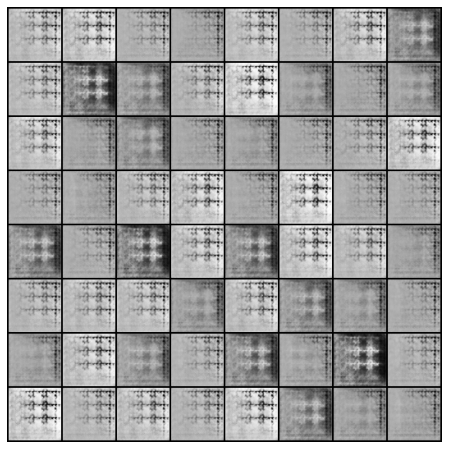

In [9]:
animate_gen_imgs()

# Trian : izif E

In [10]:
DC.eval()
D.eval()

kappa = 1.0
EC_losses = []

iters = 0
AE_img_list = []

def train_AE(epoch):
    global epochs
    global iters
    global EC_losses
    global AE_img_list
    
    # 인덱스 0부터 세기 시작
    # data[0].size():64x1x64x64(image) / data[1].size():64(label)
    for i,data in enumerate(data_loader,0):
        
        real_imgs = data[0].to(device)
        
        EC_optimizer.zero_grad()
        
        EC_validity = EC(real_imgs)
        
        fake_imgs = DC(EC_validity)
        
        _, real_features = D.forward(real_imgs)
        _, fake_features = D.forward(fake_imgs)
        
        
        # izif architecture
        imgs_loss = AE_criterion(real_imgs, fake_imgs)
        features_loss = AE_criterion(real_features, fake_features)
        EC_loss = imgs_loss + kappa*features_loss
        
        EC_loss.backward()
        EC_optimizer.step()
        
        # =============================================================
        # print
        # =============================================================
        print('[%d/%d][%d/%d]\n- E_loss: %.4f\n'
              %(epoch+1, epochs, i, len(data_loader), EC_loss.item()))
        
        # Save Losses for plotting later
        EC_losses.append(EC_loss.item())
        
        #Check how the generator is doing by saving G's output on noise_z
        if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(data_loader)-1)):
            with torch.no_grad():
                fake = DC(EC_validity).detach().cpu()
            AE_img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
        
#torch.save(E.state_dict(), 'E.ckpt')

In [11]:
for epoch in range(epochs):
    train_AE(epoch)

[1/100][0/15]
- E_loss: 0.1398

[1/100][1/15]
- E_loss: 0.1322

[1/100][2/15]
- E_loss: 0.1636

[1/100][3/15]
- E_loss: 0.1547

[1/100][4/15]
- E_loss: 0.1179

[1/100][5/15]
- E_loss: 0.1235

[1/100][6/15]
- E_loss: 0.1289

[1/100][7/15]
- E_loss: 0.1412

[1/100][8/15]
- E_loss: 0.1408

[1/100][9/15]
- E_loss: 0.1449

[1/100][10/15]
- E_loss: 0.1260

[1/100][11/15]
- E_loss: 0.1066

[1/100][12/15]
- E_loss: 0.0947

[1/100][13/15]
- E_loss: 0.1314

[1/100][14/15]
- E_loss: 0.1266

[2/100][0/15]
- E_loss: 0.1123

[2/100][1/15]
- E_loss: 0.1310

[2/100][2/15]
- E_loss: 0.1017

[2/100][3/15]
- E_loss: 0.1426

[2/100][4/15]
- E_loss: 0.1224

[2/100][5/15]
- E_loss: 0.1091

[2/100][6/15]
- E_loss: 0.1037

[2/100][7/15]
- E_loss: 0.1288

[2/100][8/15]
- E_loss: 0.1460

[2/100][9/15]
- E_loss: 0.1026

[2/100][10/15]
- E_loss: 0.0880

[2/100][11/15]
- E_loss: 0.1290

[2/100][12/15]
- E_loss: 0.0922

[2/100][13/15]
- E_loss: 0.1150

[2/100][14/15]
- E_loss: 0.1040

[3/100][0/15]
- E_loss: 0.1138

[17/100][12/15]
- E_loss: 0.1131

[17/100][13/15]
- E_loss: 0.0938

[17/100][14/15]
- E_loss: 0.1085

[18/100][0/15]
- E_loss: 0.1238

[18/100][1/15]
- E_loss: 0.1033

[18/100][2/15]
- E_loss: 0.0937

[18/100][3/15]
- E_loss: 0.1014

[18/100][4/15]
- E_loss: 0.1038

[18/100][5/15]
- E_loss: 0.0855

[18/100][6/15]
- E_loss: 0.0986

[18/100][7/15]
- E_loss: 0.1096

[18/100][8/15]
- E_loss: 0.0970

[18/100][9/15]
- E_loss: 0.1029

[18/100][10/15]
- E_loss: 0.0939

[18/100][11/15]
- E_loss: 0.0903

[18/100][12/15]
- E_loss: 0.1036

[18/100][13/15]
- E_loss: 0.0958

[18/100][14/15]
- E_loss: 0.1124

[19/100][0/15]
- E_loss: 0.1165

[19/100][1/15]
- E_loss: 0.1266

[19/100][2/15]
- E_loss: 0.1114

[19/100][3/15]
- E_loss: 0.0982

[19/100][4/15]
- E_loss: 0.1352

[19/100][5/15]
- E_loss: 0.0959

[19/100][6/15]
- E_loss: 0.1010

[19/100][7/15]
- E_loss: 0.0797

[19/100][8/15]
- E_loss: 0.0886

[19/100][9/15]
- E_loss: 0.0949

[19/100][10/15]
- E_loss: 0.0884

[19/100][11/15]
- E_loss: 0.0804



[34/100][3/15]
- E_loss: 0.0923

[34/100][4/15]
- E_loss: 0.1056

[34/100][5/15]
- E_loss: 0.1241

[34/100][6/15]
- E_loss: 0.0885

[34/100][7/15]
- E_loss: 0.1036

[34/100][8/15]
- E_loss: 0.0937

[34/100][9/15]
- E_loss: 0.1298

[34/100][10/15]
- E_loss: 0.0867

[34/100][11/15]
- E_loss: 0.0896

[34/100][12/15]
- E_loss: 0.0955

[34/100][13/15]
- E_loss: 0.0850

[34/100][14/15]
- E_loss: 0.0854

[35/100][0/15]
- E_loss: 0.0897

[35/100][1/15]
- E_loss: 0.0942

[35/100][2/15]
- E_loss: 0.1083

[35/100][3/15]
- E_loss: 0.1118

[35/100][4/15]
- E_loss: 0.0985

[35/100][5/15]
- E_loss: 0.0854

[35/100][6/15]
- E_loss: 0.1051

[35/100][7/15]
- E_loss: 0.1081

[35/100][8/15]
- E_loss: 0.0903

[35/100][9/15]
- E_loss: 0.0935

[35/100][10/15]
- E_loss: 0.1259

[35/100][11/15]
- E_loss: 0.0972

[35/100][12/15]
- E_loss: 0.1011

[35/100][13/15]
- E_loss: 0.0829

[35/100][14/15]
- E_loss: 0.0891

[36/100][0/15]
- E_loss: 0.0846

[36/100][1/15]
- E_loss: 0.0963

[36/100][2/15]
- E_loss: 0.0977



[50/100][9/15]
- E_loss: 0.1077

[50/100][10/15]
- E_loss: 0.0750

[50/100][11/15]
- E_loss: 0.1116

[50/100][12/15]
- E_loss: 0.0985

[50/100][13/15]
- E_loss: 0.0853

[50/100][14/15]
- E_loss: 0.0972

[51/100][0/15]
- E_loss: 0.1019

[51/100][1/15]
- E_loss: 0.1013

[51/100][2/15]
- E_loss: 0.0908

[51/100][3/15]
- E_loss: 0.0836

[51/100][4/15]
- E_loss: 0.0775

[51/100][5/15]
- E_loss: 0.0896

[51/100][6/15]
- E_loss: 0.0930

[51/100][7/15]
- E_loss: 0.0940

[51/100][8/15]
- E_loss: 0.1324

[51/100][9/15]
- E_loss: 0.0902

[51/100][10/15]
- E_loss: 0.0922

[51/100][11/15]
- E_loss: 0.0810

[51/100][12/15]
- E_loss: 0.1116

[51/100][13/15]
- E_loss: 0.0886

[51/100][14/15]
- E_loss: 0.0990

[52/100][0/15]
- E_loss: 0.0928

[52/100][1/15]
- E_loss: 0.0884

[52/100][2/15]
- E_loss: 0.0900

[52/100][3/15]
- E_loss: 0.0902

[52/100][4/15]
- E_loss: 0.0886

[52/100][5/15]
- E_loss: 0.0962

[52/100][6/15]
- E_loss: 0.0947

[52/100][7/15]
- E_loss: 0.1088

[52/100][8/15]
- E_loss: 0.0912



[67/100][0/15]
- E_loss: 0.1102

[67/100][1/15]
- E_loss: 0.0918

[67/100][2/15]
- E_loss: 0.0909

[67/100][3/15]
- E_loss: 0.1056

[67/100][4/15]
- E_loss: 0.0966

[67/100][5/15]
- E_loss: 0.0711

[67/100][6/15]
- E_loss: 0.1094

[67/100][7/15]
- E_loss: 0.0981

[67/100][8/15]
- E_loss: 0.0909

[67/100][9/15]
- E_loss: 0.0932

[67/100][10/15]
- E_loss: 0.0966

[67/100][11/15]
- E_loss: 0.0962

[67/100][12/15]
- E_loss: 0.0913

[67/100][13/15]
- E_loss: 0.0933

[67/100][14/15]
- E_loss: 0.1047

[68/100][0/15]
- E_loss: 0.0939

[68/100][1/15]
- E_loss: 0.0922

[68/100][2/15]
- E_loss: 0.0866

[68/100][3/15]
- E_loss: 0.1127

[68/100][4/15]
- E_loss: 0.1123

[68/100][5/15]
- E_loss: 0.0789

[68/100][6/15]
- E_loss: 0.0847

[68/100][7/15]
- E_loss: 0.0799

[68/100][8/15]
- E_loss: 0.0821

[68/100][9/15]
- E_loss: 0.1232

[68/100][10/15]
- E_loss: 0.1138

[68/100][11/15]
- E_loss: 0.0889

[68/100][12/15]
- E_loss: 0.0986

[68/100][13/15]
- E_loss: 0.1052

[68/100][14/15]
- E_loss: 0.0818



[83/100][6/15]
- E_loss: 0.0992

[83/100][7/15]
- E_loss: 0.1118

[83/100][8/15]
- E_loss: 0.0996

[83/100][9/15]
- E_loss: 0.0984

[83/100][10/15]
- E_loss: 0.0991

[83/100][11/15]
- E_loss: 0.1040

[83/100][12/15]
- E_loss: 0.0817

[83/100][13/15]
- E_loss: 0.0917

[83/100][14/15]
- E_loss: 0.0837

[84/100][0/15]
- E_loss: 0.0837

[84/100][1/15]
- E_loss: 0.1093

[84/100][2/15]
- E_loss: 0.0921

[84/100][3/15]
- E_loss: 0.0911

[84/100][4/15]
- E_loss: 0.0997

[84/100][5/15]
- E_loss: 0.0785

[84/100][6/15]
- E_loss: 0.0995

[84/100][7/15]
- E_loss: 0.0916

[84/100][8/15]
- E_loss: 0.0744

[84/100][9/15]
- E_loss: 0.1252

[84/100][10/15]
- E_loss: 0.0857

[84/100][11/15]
- E_loss: 0.0890

[84/100][12/15]
- E_loss: 0.0871

[84/100][13/15]
- E_loss: 0.0946

[84/100][14/15]
- E_loss: 0.0862

[85/100][0/15]
- E_loss: 0.0828

[85/100][1/15]
- E_loss: 0.0974

[85/100][2/15]
- E_loss: 0.0944

[85/100][3/15]
- E_loss: 0.0680

[85/100][4/15]
- E_loss: 0.1166

[85/100][5/15]
- E_loss: 0.0900



[99/100][12/15]
- E_loss: 0.0791

[99/100][13/15]
- E_loss: 0.1157

[99/100][14/15]
- E_loss: 0.1056

[100/100][0/15]
- E_loss: 0.0874

[100/100][1/15]
- E_loss: 0.1056

[100/100][2/15]
- E_loss: 0.0874

[100/100][3/15]
- E_loss: 0.1012

[100/100][4/15]
- E_loss: 0.0850

[100/100][5/15]
- E_loss: 0.0850

[100/100][6/15]
- E_loss: 0.0936

[100/100][7/15]
- E_loss: 0.1021

[100/100][8/15]
- E_loss: 0.0727

[100/100][9/15]
- E_loss: 0.1038

[100/100][10/15]
- E_loss: 0.0879

[100/100][11/15]
- E_loss: 0.0881

[100/100][12/15]
- E_loss: 0.1054

[100/100][13/15]
- E_loss: 0.0883

[100/100][14/15]
- E_loss: 0.0922



# Loss Graph

In [12]:
def plot_train_loss():
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(DC_losses, label="G")
    plt.plot(D_losses, label="D")
    plt.plot(EC_losses, label="E")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

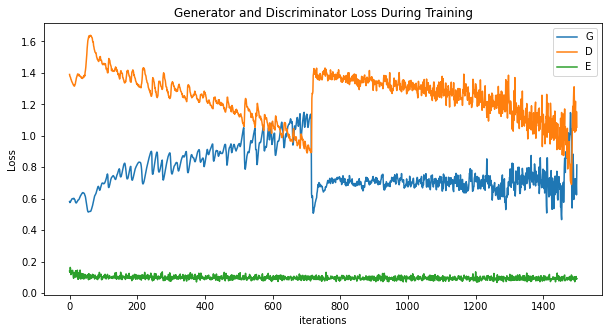

In [13]:
plot_train_loss()

---

# Test Data

In [14]:
#test_data_root = "../../dataset/test/test_DualPhaseSteel"
Ti64_test_data_root = "../../dataset/test/test_Ti64"

test_data_set = dataset.ImageFolder(root = Ti64_test_data_root, # test_data_root,
                           transform = transforms.Compose([
                                  transforms.Resize(img_size),
                                  transforms.CenterCrop(img_size),
                                  torchvision.transforms.Grayscale(channel),
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.5,),(0.5,))
                              ]))

# 배치로 나누고 셔플하기
test_data_loader = torch.utils.data.DataLoader(test_data_set, batch_size = 1,
                                              shuffle = False, num_workers = workers)

# 이상 픽셀 수 확인 함수

In [15]:
def count_el_not_0(diff_img):
    count_el_not_0 = 0
    
    col_size = diff_img.shape[0]
    row_size = diff_img.shape[1]
    
    #print(col_size, row_size)
    
    for col in range(col_size):
        for row in range(row_size):
            if diff_img[col][row] != 0:
                count_el_not_0 += 1
                
    return count_el_not_0

# img 비교 함수

In [16]:
def compare_imgs(real_img, generated_img, i, score, reverse=False, threshold=50):
    real_img = real_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    generated_img = generated_img.cpu().data.numpy().reshape(img_size, img_size) * 255
    
    negative = np.zeros_like(real_img)

    if not reverse:
        diff_img = real_img - generated_img
    else:
        diff_img = generated_img - real_img

    diff_img[diff_img <= threshold] = 0

    # 분율 추출
    diff_cnts.append(count_el_not_0(diff_img))
    # 분산 추출
    diff_points.append(np.where(diff_img > threshold))
    
    anomaly_img = np.zeros(shape=(img_size, img_size, 3))
    anomaly_img[:, :, 0] = real_img - diff_img
    anomaly_img[:, :, 1] = real_img - diff_img
    anomaly_img[:, :, 2] = real_img - diff_img
    anomaly_img[:, :, 0] = anomaly_img[:,:,0] + diff_img
    anomaly_img = anomaly_img.astype(np.uint8)

    # anomaly_img 추출
    anomaly_imgs.append(anomaly_img)
    
    fig, plots = plt.subplots(1, 4)

    fig.suptitle(f'Anomaly - (anomaly score: {score:.4})')
    
    fig.set_figwidth(9)
    fig.set_tight_layout(True)
    plots = plots.reshape(-1)
    plots[0].imshow(real_img, cmap='gray', label = "real")
    plots[1].imshow(generated_img, cmap='gray')
    plots[2].imshow(diff_img, cmap='gray')
    plots[3].imshow(anomaly_img)
    
    plots[0].set_title('real')
    plots[1].set_title('generated')
    plots[2].set_title('difference')
    plots[3].set_title('Anomaly Detection')
    plt.show()

# Test

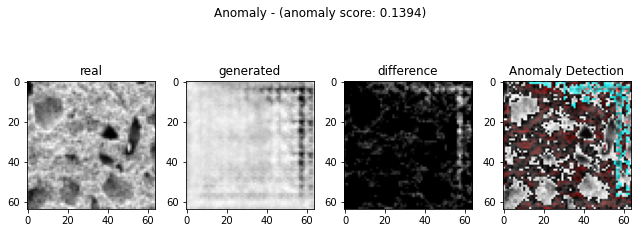

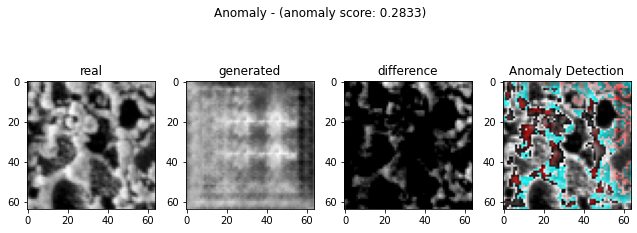

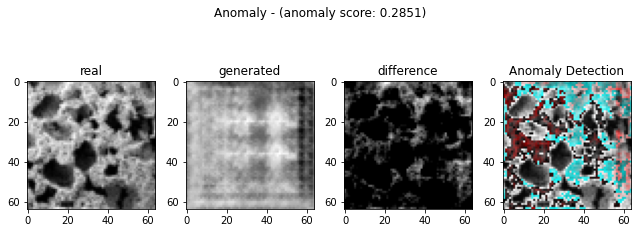

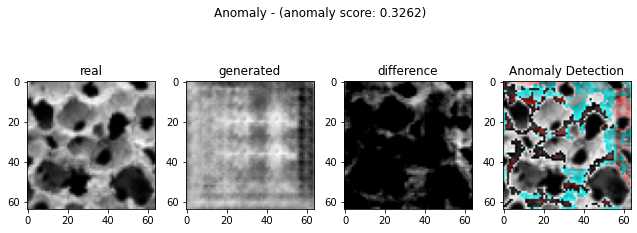

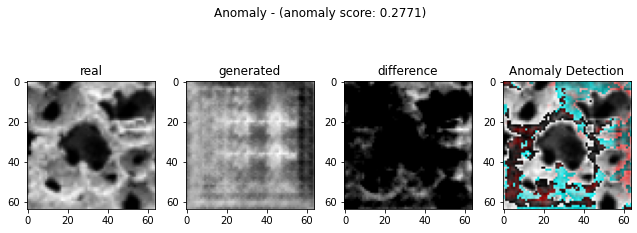

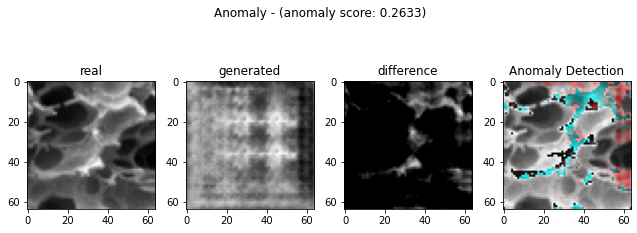

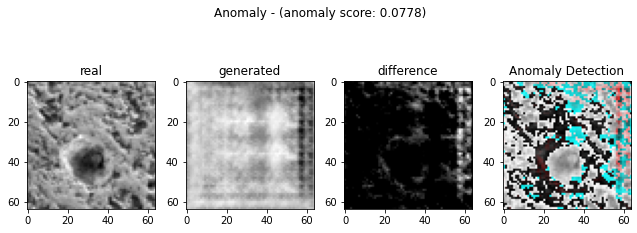

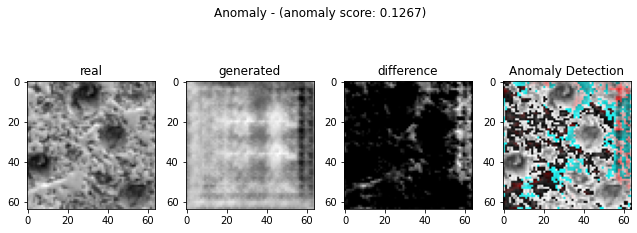

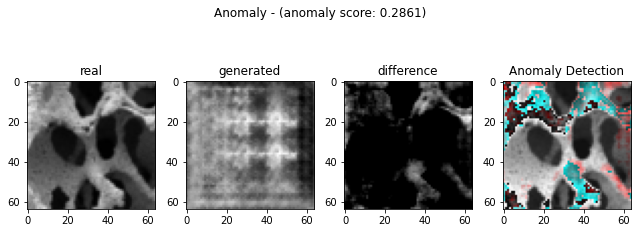

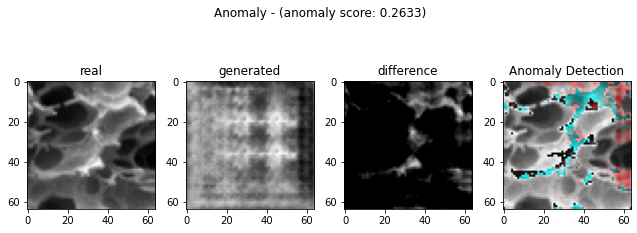

In [17]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

ano_criterion = nn.MSELoss()
DC.eval()
D.eval()
EC.eval()

# with open("score.csv", "w") as f:
#         f.write("label,img_distance,anomaly_score,z_distance\n")

for i, data in enumerate(test_data_loader, 0):
    real_img = data[0].to(device)

    real_z = EC(real_img) # 진짜 이미지의 latent vector
    fake_img = DC(real_z) # DC에 넣어서 가짜 이미지 생성.
    fake_z = EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

    _, real_feature = D.forward(real_img) # 1, 256
    _, fake_feature = D.forward(fake_img)

    img_distance = ano_criterion(fake_img, real_img)
    loss_feature = ano_criterion(fake_feature, real_feature)

    anomaly_score = img_distance + kappa*loss_feature

    z_distance = ano_criterion(fake_z, real_z)
    
#     with open("score.csv", "a") as f:
#             f.write(f"{label.item()},{img_distance},"
#                     f"{anomaly_score},{z_distance}\n")
            
#     print(f"{label.item()}, {img_distance}, "
#           f"{anomaly_score}, {z_distance}\n")
    compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

---

# 분율 추출

In [18]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.41381836 0.4140625  0.46118164 0.38623047 0.43457031 0.2824707
 0.35961914 0.36621094 0.35058594 0.2824707 ]


In [19]:
sum(diff_fraction)/len(diff_fraction)

0.3751220703125

---

# 분산 추출

In [20]:
from scipy import stats
from extended_int import int_inf

corr_coeffis = []
corr_p_vals = []

def cal_corr_coeffis():
    for idx in range(len(test_data_loader)):
        x_points = diff_points[idx][0]
        y_points = diff_points[idx][1]
        
        
        if len(x_points) > 0:
            corr_coeffi, corr_p_val = stats.pearsonr(x_points, y_points)
        else:
            corr_coeffi, corr_p_val = -int_inf, -int_inf
        
        corr_coeffis.append(corr_coeffi)
        corr_p_vals.append(corr_p_val)

In [21]:
cal_corr_coeffis()

print(corr_coeffis)

[0.005535229367137221, 0.0074768232554807195, 0.04205390746848625, 0.014538865803387402, -0.16744691439409162, -0.017059668673657786, 0.023471684651706064, -0.14552756590066096, 0.0988774493426664, -0.017059668673657786]


---

# 모델 저장 및 읽기

In [22]:
save_file = "./pretrained/pretrained.pth"

def save_pretrained():
    pretrained = {
        "D" : D.state_dict(),
        "DC" : DC.state_dict(),
        "EC" : EC.state_dict()
    }

    if not os.path.isdir("pretrained"):
        os.mkdir("pretrained")
    torch.save(pretrained, save_file)

In [23]:
save_pretrained()

In [24]:
pretrained_D = Discriminator().to(device)
pretrained_DC = Decoder().to(device)
pretrained_EC = Encoder().to(device)

def load_pretrained():
    global pretrained_D
    global pretrained_DC
    global pretrained_EC
    
    assert os.path.isdir("pretrained"), "Error : no pretrained dir found!"
    
    pretrained = torch.load(save_file)
    
    pretrained_D.load_state_dict(pretrained["D"])
    pretrained_DC.load_state_dict(pretrained["DC"])
    pretrained_EC.load_state_dict(pretrained["EC"])
    
    #print("pretrained_D :", pretrained_D)
    #print("pretrained_G :", pretrained_DC)
    #print("pretrained_E :", pretrained_EC)

In [25]:
load_pretrained()

In [26]:
def test():
    ano_criterion = nn.MSELoss()
    pretrained_DC.eval()
    pretrained_D.eval()
    pretrained_EC.eval()

    # with open("score.csv", "w") as f:
    #         f.write("label,img_distance,anomaly_score,z_distance\n")

    for i, data in enumerate(test_data_loader, 0):
        real_img = data[0].to(device)

        real_z = pretrained_EC(real_img) # 진짜 이미지의 latent vector
        fake_img = pretrained_DC(real_z) # DC에 넣어서 가짜 이미지 생성.
        fake_z = pretrained_EC(fake_img) # torch.Size([1, 100]) --> latent 진짜 이미지와 매핑된 가짜 이미지의 latent vector

        _, real_feature = pretrained_D.forward(real_img) # 1, 256
        _, fake_feature = pretrained_D.forward(fake_img)

        img_distance = ano_criterion(fake_img, real_img)
        loss_feature = ano_criterion(fake_feature, real_feature)

        anomaly_score = img_distance + kappa*loss_feature

        z_distance = ano_criterion(fake_z, real_z)

    #     with open("score.csv", "a") as f:
    #             f.write(f"{label.item()},{img_distance},"
    #                     f"{anomaly_score},{z_distance}\n")

    #     print(f"{label.item()}, {img_distance}, "
    #           f"{anomaly_score}, {z_distance}\n")
        compare_imgs(real_img, fake_img, i, anomaly_score, reverse = False, threshold = 0.3)

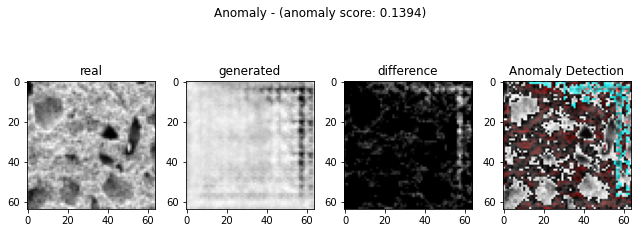

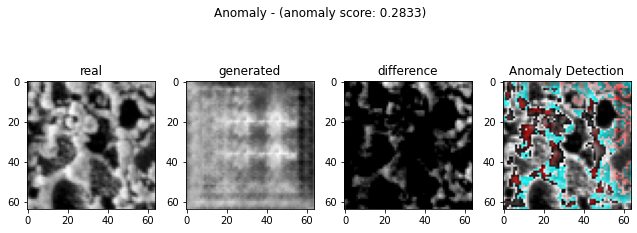

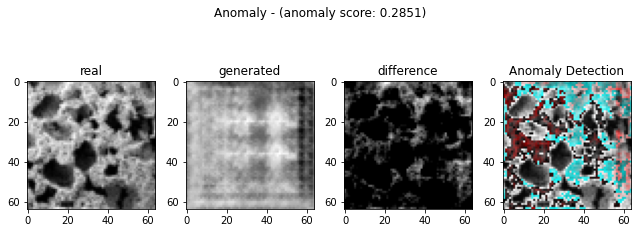

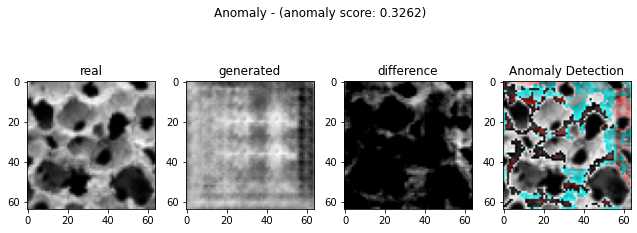

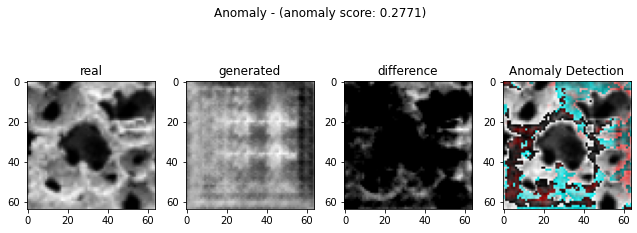

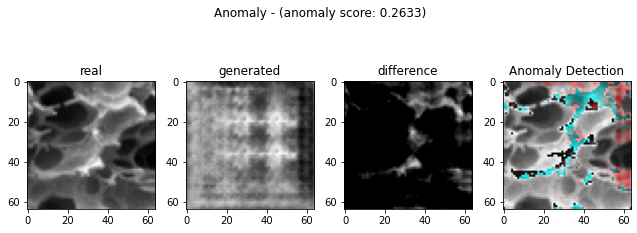

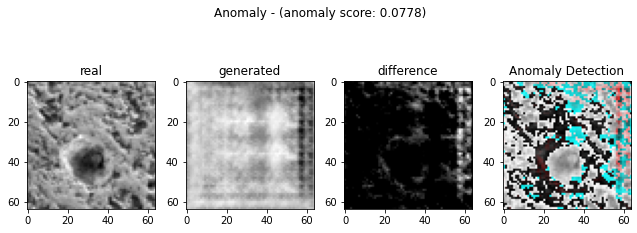

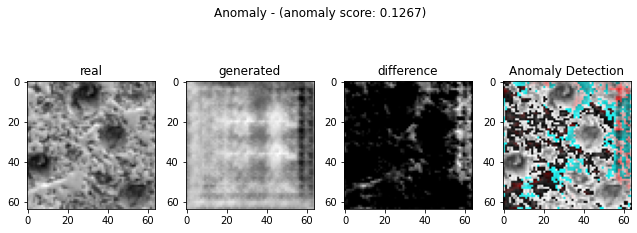

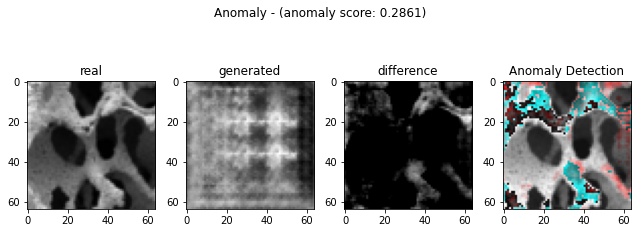

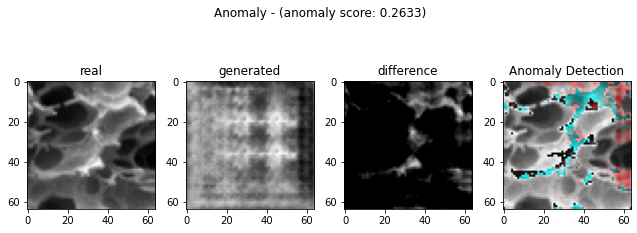

In [27]:
diff_cnts = []
diff_points = []
anomaly_imgs = []

corr_coeffis = []
corr_p_vals = []

test()

In [28]:
diff_cnts = np.array(diff_cnts)

diff_fraction = diff_cnts / img_size ** 2

print(diff_fraction)

[0.41381836 0.4140625  0.46118164 0.38623047 0.43457031 0.2824707
 0.35961914 0.36621094 0.35058594 0.2824707 ]


In [29]:
cal_corr_coeffis()

print(corr_coeffis)

[0.005535229367137221, 0.0074768232554807195, 0.04205390746848625, 0.014538865803387402, -0.16744691439409162, -0.017059668673657786, 0.023471684651706064, -0.14552756590066096, 0.0988774493426664, -0.017059668673657786]


---

# anomaly detection 이미지 추출

In [30]:
anomaly_imgs

[array([[[ 15,  15,  15],
         [186, 186, 186],
         [113,  60,  60],
         ...,
         [ 51,  29,  29],
         [117,  52,  52],
         [111,  59,  59]],
 
        [[  5,   5,   5],
         [ 35,  35,  35],
         [204, 204, 204],
         ...,
         [ 49,  13,  13],
         [ 61,  26,  26],
         [ 53,  53,  53]],
 
        [[  7,   7,   7],
         [  9,   9,   9],
         [ 57,  57,  57],
         ...,
         [192, 192, 192],
         [238, 238, 238],
         [ 75,  42,  42]],
 
        ...,
 
        [[113, 113, 113],
         [158, 158, 158],
         [184, 184, 184],
         ...,
         [ 55,  55,  55],
         [ 45,  43,  43],
         [ 53,  51,  51]],
 
        [[132, 132, 132],
         [176, 176, 176],
         [202, 202, 202],
         ...,
         [246, 246, 246],
         [ 17,  17,  17],
         [ 41,  37,  37]],
 
        [[121, 121, 121],
         [178, 178, 178],
         [134, 134, 134],
         ...,
         [162, 162, 162],
  

# 이미지 저장 함수

In [31]:
import cv2

def save_imgs(folder, imgs):
    if not os.path.isdir("anomaly_imgs"):
        os.mkdir("anomaly_imgs")
    
    for i in range(len(imgs)):
        cv2.imwrite('%s/%d.png' %(folder,i), imgs[i]) #이미지 저장할 경로 설정을 여기서 한다.
    print("image saving complete")

In [32]:
save_imgs("./anomaly_imgs", anomaly_imgs)

image saving complete


---

# 티타늄(Ti64) 상대 밀도 계산

In [33]:
Ti64_density = 4.43

Ti64_rel_densitys = np.array([])

Ti64_rel_densitys = diff_fraction * Ti64_density

print(Ti64_rel_densitys)

[1.83321533 1.83429687 2.04303467 1.71100098 1.92514648 1.25134521
 1.59311279 1.62231445 1.5530957  1.25134521]
